# [Explortaion 4] 네이버 영화리뷰 감성분석 😃

## 1) 데이터 준비와 확인

네이버 영화에 댓글을 모아둔 데이터셋을 아래의 경로를 통해 다운로드 후, 디렉토리로 옮겨준다.

```$ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt```   
```$ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt```   
```$ mv ratings_*.txt ~/aiffel/sentiment_classificati```

데이터가 잘 다운로드 되어 준비되었는지 확인.

In [2]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


다운로드된 데이터셋을 보면 레이블이 정확한것 같지 않다.   
0번째 데이터를 보면 레이블이 '0'으로 부정을 표현한 것 같은데,   
2번째 데이터를 보면 재밌어서 추천을 하는데도 '0'레이블을 보이고 있다.   

## 2) 데이터로더 구성

네이버 영화리뷰 데이터셋은 전혀 가공되지 않은 테스트의 데이터로, 숫자 인덱스로 변환후 딕셔너리 형태로 가공해야한다.   
쉽게 말해 데이터 전처리를 하는 과정이라고 보면 된다. Imdb 데이터셋은 이미 전처리가 다 되어 있는 상태라 이 과정을 생략했지만 네이버 영화댓글 데이터셋은 날것?의 상태이다..

- 데이터 중복제거
- NaN 결측치 제거
- 한국어 토크나이저 토큰화
- 불용아(Stopwords) 제거
- 사전 word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴   
   
   
아래 코드와 같이 실행하여 위 조건들을 준비하였다.

In [3]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

index_to_word = {index:word for word, index in word_to_index.items()}

위 코드를 실행할 때 에러가 많이 있었다.   
이유를 알지 못하는 문제가 생겼었는데 혼자 힘으로 해결해보려고 하니 알수 없는 문제가 계속 생겼다.   
문제를 해결하려다보니 문제가 생기고 모르는 단어가 생기고 또 그걸 이해하려고 계속계속 문제들은 생기고 깊어져만 갔다.   
결국은 퍼실님이 참고하라고 알려주신 블로그를 참고하여 해결하였다...   
   
   
구글링도 능력이라고 했다. 어떤 문제인지 인식하고 자신 스스로 해결하는 것도 능력이라는걸 깨달았다.   
(이에 대해서는 밑 회고 부분에 조금 더 자세히 적겠다.)

### 텍스트를 숫자로 표현하기

위에서 확인했듯이, 각 단어들을 딕셔너리 형태로 Key : 번호, Value : 문자를 넣었다.   
하지만 컴퓨터는 숫자로 텍스트값을 표현할 수 있으니 key를 텍스트값으로 바꿔줘야한다.   
아래 함수들은 한문장 혹은 여러문장을 인덱스로 바꿔주는 함수,   
인덱스로 encoded된 번호를 다시 text decoding하는 함수이다.


In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [5]:
print(get_encoded_sentence('이번 영화는 너무 재미가 없었다', word_to_index))

[1, 778, 2, 24, 2, 2]


각 단어에 대한 번호가 나왔다. 번호 2번은 Unknown 텍스트를 말하는데 **'영화는', '재미가', '없었다'** 에 대한건 학습이 안된것 같다.  
이번에는 반대로 아무 번호를 입력했을 시에 어떤 단어가 나오는지 확인해보겠다.

In [6]:
print(get_decoded_sentence((1, 778, 23,24,9999,10000), index_to_word))

이번 는데 너무 실로 <UNK>


---------------------------------------------------------------------------------------------------   
   
   
   
아무 번호나 입력했을 시 각 번호에 해당하는 텍스트값을 찾을 수 있었다.   
10000번째인 9999를 입력했을시는 텍스트값을 확인할 수 있는데,   
10001번째인 10000을 입력 했을시는 unknown값이 나온다. 즉, train dataset에는 10000개의 텍스트값이 있음을 확인하였다.

## 3) 모델구성을 위한 데이터 분석 및 가공


- 데이터셋 내 문장 길이 분포 & 적절한 최대 문장 길이 지정


문장 길이 분포를 확인하기전에 먼저, 패딩과 Unknown, Unused 단어를 구분하기 위해 word_to_index를 기준으로 각 단어를 3칸씩 뒤로 밀어준다.   
이후 0~3까지의 value는 각각 PAD, BOS, UNK, UNUSED 값으로 채워준다.

In [7]:
#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  
word_to_index = {k:(v) for k,v in word_to_index.items()}

In [8]:
print(word_to_index)

{'<PAD>': 0, '<BOS>': 1, '<UNK>': 2, '<UNUSED>': 3, '.': 4, '영화': 5, '다': 6, '고': 7, '하': 8, '을': 9, '보': 10, '..': 11, '게': 12, ',': 13, '!': 14, '지': 15, '있': 16, '없': 17, '?': 18, '좋': 19, '나': 20, '었': 21, '만': 22, '는데': 23, '너무': 24, '봤': 25, '적': 26, '안': 27, '정말': 28, '로': 29, '음': 30, '것': 31, '아': 32, '네요': 33, '재밌': 34, '어': 35, '같': 36, '점': 37, '지만': 38, '진짜': 39, '했': 40, '에서': 41, '기': 42, '네': 43, '않': 44, '거': 45, '았': 46, '수': 47, '되': 48, '면': 49, 'ㅋㅋ': 50, '말': 51, '연기': 52, '인': 53, '주': 54, '내': 55, '최고': 56, '~': 57, '평점': 58, '이런': 59, '던': 60, '어요': 61, '할': 62, '왜': 63, '겠': 64, '1': 65, '스토리': 66, '해': 67, '습니다': 68, 'ㅋㅋㅋ': 69, '...': 70, '드라마': 71, '생각': 72, '아니': 73, '더': 74, '그': 75, '싶': 76, '사람': 77, '듯': 78, '때': 79, '감동': 80, '함': 81, '배우': 82, '본': 83, '까지': 84, '뭐': 85, '알': 86, '만들': 87, '내용': 88, '볼': 89, '감독': 90, '보다': 91, '라': 92, '그냥': 93, '재미': 94, '시간': 95, '지루': 96, '중': 97, '재미있': 98, '년': 99, '10': 100, '였': 101, '잼': 102, '사랑': 103, '못': 1

In [9]:

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word[0] = "<PAD>"
index_to_word[1] = "<BOS>"
index_to_word[2] = "<UNK>"
index_to_word[3] = "<UNUSED>"

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[22])    
print(word_to_index['the'])  
print(index_to_word[1424])     

만
1909
줘서


다음 스텝으로는, **keras**에서 지원하는 **pad_sequences**를 통해 전체 문장의 길이를 맞춰준다.  
**numpy**를 활용하여 문장의 평균, 최대, 표준편차값을 구할 수 있다. **적정한 길이의 문장을 기준**으로 하여 (모든 문장 길이로 했을 시에는 너무 많은 패딩값이 들어가 **long_dependency** 현상이 발생할 수 있음) maxlen 값을 정한다.   
최대 길이를 (평균 x 2x표준편차)로 하여 **41글자**로 정하였으며 이는 전체문장의 **93%**가 포함된다.

In [10]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96938143432699
문장길이 최대 :  116
문장길이 표준편차 :  12.843571939469296
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [11]:
x_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

import tensorflow as tf

from tensorflow import keras

import numpy as np



print(tf.__version__)

(146182, 41)
2.2.0


패딩은 당연히 pre를 사용하였다. post로 할 경우, 앞부분에서 학습된 것들은 그 의미가 희미해지는 long-dependency 현상이 발생한다고 한다.

## 4) 모델구성 및 validation set 구성

In [12]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 20  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 20)          200000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 928       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 201,009
Trainable params: 201,009
Non-trainable params: 0
_________________________________________________________________


아래 평가에서 정확도가 잘 나오지 않아 dim값을 20으로 올렸다. 하지만 큰 차이는 느끼지 못한것 같다.

In [13]:
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(y_val.shape)
print(x_val.shape)
print(partial_x_train.shape)
print(partial_y_train.shape)

(10000,)
(10000, 41)
(136182, 41)
(136182,)


트레인셋에서 validation셋을 Split 하였다. 10000개를 validation set으로 세팅하고 나머지 전부를 train set으로 설정하였다.   
이렇게 보니 전체 데이터셋은 146182개였다.

## 5) 모델 훈련 개시

In [44]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=2)

Epoch 1/20
266/266 - 1s - loss: 0.2335 - accuracy: 0.9081 - val_loss: 0.3513 - val_accuracy: 0.8559
Epoch 2/20
266/266 - 1s - loss: 0.2124 - accuracy: 0.9184 - val_loss: 0.3669 - val_accuracy: 0.8496
Epoch 3/20
266/266 - 1s - loss: 0.1884 - accuracy: 0.9302 - val_loss: 0.3886 - val_accuracy: 0.8496
Epoch 4/20
266/266 - 1s - loss: 0.1638 - accuracy: 0.9412 - val_loss: 0.4288 - val_accuracy: 0.8479
Epoch 5/20
266/266 - 1s - loss: 0.1421 - accuracy: 0.9508 - val_loss: 0.4557 - val_accuracy: 0.8386
Epoch 6/20
266/266 - 1s - loss: 0.1228 - accuracy: 0.9585 - val_loss: 0.4801 - val_accuracy: 0.8425
Epoch 7/20
266/266 - 1s - loss: 0.1044 - accuracy: 0.9664 - val_loss: 0.5178 - val_accuracy: 0.8374
Epoch 8/20
266/266 - 1s - loss: 0.0914 - accuracy: 0.9709 - val_loss: 0.5649 - val_accuracy: 0.8335
Epoch 9/20
266/266 - 1s - loss: 0.0795 - accuracy: 0.9752 - val_loss: 0.5943 - val_accuracy: 0.8312
Epoch 10/20
266/266 - 1s - loss: 0.0719 - accuracy: 0.9784 - val_loss: 0.6432 - val_accuracy: 0.8349

In [45]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.9996 - accuracy: 0.8181
[0.9996420741081238, 0.818113386631012]


에폭값을 너무 높게 줘서 그런지 학습이 되면 될수록 loss가 말도 안되게 높아지고 정확도도 떨어졌다. 그래프로 적정값을 확인하고 진행해보자.

## 6) Loss, Accuracy 그래프 시각화

In [49]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


히스토리 변수에 저장된 값은 **train set**의 **loss**와 **accuracyy** 그리고 **alidation set**의 **loss**와 **accuracy**이다.

[0.9081302881240845, 0.9184253215789795, 0.930211067199707, 0.9411522746086121, 0.9508011341094971, 0.9585187435150146, 0.9664345979690552, 0.9708918929100037, 0.9752243161201477, 0.9783892035484314, 0.9811355471611023, 0.9834045767784119, 0.9846822619438171, 0.9852917194366455, 0.9864813089370728, 0.9875680804252625, 0.9870614409446716, 0.9883464574813843, 0.9892203211784363, 0.9895433783531189]


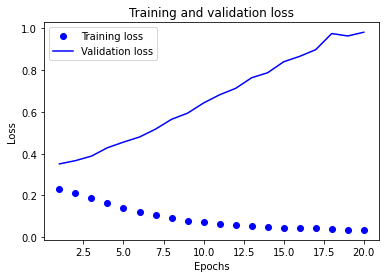

In [50]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
print(acc)
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

트레인이 진행되면 될수록 train set의 loss는 떨어지는데 validation의 loss는 커지는게 이해가 안됐다.

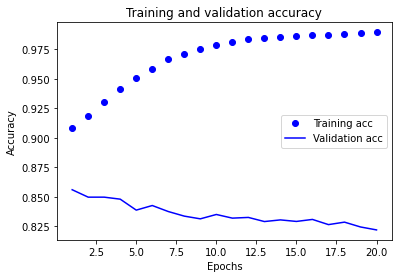

In [51]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

accuracy도 마찬가지로 val set은 떨어지고 train set만 올라가는 모습을 보인다. 적정 epoch값을 정하는게 더욱 중요해졌다.

## 7) 학습된 Embedding 레이어 분석

In [19]:
import os

embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec1.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

(10000, 20)


임베딩 하기 위하여 txt파일을 지정하고 앞서 dimention값을 정했던대로 20열의 lookup table을 만든다.

In [20]:
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['감독']
vector

array([-0.03022075,  0.08833101,  0.0369391 ,  0.00903581,  0.03478584,
       -0.00687226, -0.09054787, -0.01626918, -0.006967  ,  0.04473749,
        0.11857208, -0.06390212,  0.03107567, -0.06100384, -0.02336634,
        0.08442147, -0.12141708,  0.04442209, -0.08327898,  0.21628222],
      dtype=float32)

'감독' 이라는 단어의 array는 다음과 같이 나온다.

In [21]:
word_vectors.similar_by_word("최고")

[('완벽', 0.988400936126709),
 ('소장', 0.9852660298347473),
 ('아련', 0.9852471351623535),
 ('편한', 0.9844003319740295),
 ('데요', 0.9839940071105957),
 ('묻히', 0.9839110374450684),
 ('낚일', 0.9838437438011169),
 ('겸손', 0.9829866886138916),
 ('로라', 0.9824099540710449),
 ('굿', 0.9820712804794312)]

'최고'와 비슷한 단어의 뜻을 찾아보았는데 꽤나 비슷한 단어들을 많이 보여준다. 학습이 나름 잘 된것 같다.   
하지만 정확도가 높다는 것과는 다른 뜻이니 개선해야할 점이 있다.

## 8) 한국어 Word2Vec 임베딩 활용하여 성능개선

In [40]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 20  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)
word2vec = KeyedVectors.load_word2vec_format(word2vec_file_path, encoding='utf8', unicode_errors='strict',limit=None)
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

embedding된 벡터를 가지고 성능을 개선시키는 단계이다.   
이 부분에서 오류가 났었다. utf8과 관련된 오류였는데, aiffel 노드와 확인해보니 binary=True라는 구문이 들어가있어서 한국어세트에는 필요없겠다 싶어서 삭제했더니 오류가 사라지고 정상적으로 작동되었다. 역시 잘 안될때는 조금 쉬고 와서 보면 새롭게 보이는것 같다.

In [41]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 20  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 41, 20)            200000    
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 35, 16)            2256      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

모델을 지정한 후에,

In [42]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
266/266 [==============================] - 1s 6ms/step - loss: 0.4105 - accuracy: 0.8134 - val_loss: 0.3453 - val_accuracy: 0.8481
Epoch 2/5
266/266 [==============================] - 1s 5ms/step - loss: 0.3050 - accuracy: 0.8731 - val_loss: 0.3392 - val_accuracy: 0.8503
Epoch 3/5
266/266 [==============================] - 1s 5ms/step - loss: 0.2886 - accuracy: 0.8809 - val_loss: 0.3366 - val_accuracy: 0.8550
Epoch 4/5
266/266 [==============================] - 1s 5ms/step - loss: 0.2723 - accuracy: 0.8881 - val_loss: 0.3381 - val_accuracy: 0.8567
Epoch 5/5
266/266 [==============================] - 1s 5ms/step - loss: 0.2547 - accuracy: 0.8969 - val_loss: 0.3402 - val_accuracy: 0.8566


여러 테스트 결과 epoch이 6이하에 있을때 가장 좋은 정확도를 보였다.   
이번 평가지표에서는 5로 지정하였다.

In [43]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3572 - accuracy: 0.8501
[0.35719746351242065, 0.8501129150390625]


적정한 epoch값을 찾고, 벡터차원과 레이어층을 변경해가며 높은 정확도가 나올 수 있도록 하였다.   
다행히, 루브릭 지표에 겨우 걸친 85%가 나왔다.

# 회고:  
### 1. **이번 프로젝트에서 어려웠던 점**   
처음 노드를 한번 훑어봤을 때, 이번 프로젝트는 제출하지 못할거라 생각했다. 각 노드 페이지 과정이 진행될 때마다 어떤 흐름으로 진행되는지 전체적인 이해가 너무 어려웠다. 시간이 충분히 필요하겠다고 생각이 들었고, 주말시간을 활용해서 코드 하나하나를 뜯어보는 시간을 가졌다.   
당장 프로젝트를 끝내야겠다는 급한 마음을 뒤로하고 전체적으로 이해하는 시간을 가지고 나니, 큰흐름이 이해가 되기 시작했다. 아는만큼 보인다고, 이해하고나니 너무 재밌는 노드라는걸 깨달았다.

   
### 2. **프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점**   
문과출신인 나는 사실, 수학적인 개념이 약하다. 이전부터 계속 공부를 해오던 분들한테는 당연한 개념인 '벡터'도 나는 너무나 어려운 개념이었다. (대학생을 대학교에 다니는 학생이라고 하듯이 간단한 개념이라고 한다...). 여튼, 여기서 오는 모호한 개념 한가지는, look-up table이 어떤 개념인지 정확히 이해가 가지 않았다.   
처음 이해했을 때는 look-up table에 여러 차원을 줄 수 있고(파라미터) 가중치 w역할을 하는 것이라길래 머신이 학습을 하며 단어에 뜻을 학습해나가는 개념인 줄 알았는데 아닌것 같았다. 결국에는 이해하지 못했다. 
또 다른 모호한 점은, 위에서 그래프를 그려봤을 때, train set과 validation set의 loss와 accuracy가 epoch을 진행할 수록 격차가 커졌다. 커지면 좋지 않다고 노드에 나와있었는데 그 이유가 1. 신뢰성의 문제 때문인지, 2. 머신 성능의 문제인지 궁금하고, 격차가 커지는 그래프를 모델을 바꿔서 사용하면 그래프 모양을 바꿔서 더 최적의 값을 찾을 수 있을지 궁금하다.


### 3. **루브릭 평가 지표를 맞추기 위해 시도한 것들**   
루브릭 지표중 하나인 85% 성능을 맞추기 위해서 적절한 epoch값을 변경하고, 다양한 parameter를 수정하는데 많은 시간과 공을 들였다.   
또 다른 노력으로는, 불용단어들을 지우는 방법을 시도했었으나, 정확한 원인을 파악하지는 못했으나 차원의 문제가 발생하였다. 이 부분은 아직도 이해가 가지 않는다.
   
### 4. **만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정**   
만약 지표를 달성하지 못했다면 그 원인은 전체 프로세스와 결과를 이해하지 못해 노드를 제출하지 못했을 것이라 생각한다. 앞 1번에서도 설명하였지만, 너무나 낯설고 어려운 노드였지만 하나하나 뜯어서 공부하니 충분히 이해가 되었다. 스트레스도 받고 어려웠지만 내 자신 스스로가 뿌듯하고 자랑스럽다.
   
### 5. **자기 다짐**   
일주일에 두개 있는 프로젝트 두개를 전부 이번 프로젝트처럼 전부 이해하고 진행할 수는 없겠지만, 둘중 하나는 내 것으로 만들 수 있도록 노력해야겠다는 생각이 들었다. 지금 내가 하고 있는 이 과정이 처음 시작하는 사람들에게는 쉽지 않은 과정이란걸 안다. 그래서 더 힘들고 어렵지만 지금처럼 꾸준히 노력하다보면 6개월 뒤에는 성장해 있을 내 자신을 기대하며 포기하지 않고 노력했으면 한다.

   